# Timeseries forecasting using SARIMA

* Introduction
* Import libraries
* Preprocessing data and load
* Check the seasonality
* Setup the hyperparameters
* Make predictions - week step
* Make predictions - month step

## Introduction

This notebook is an example of time series forecasting prediction regarding the wave amplitude. Autoregressive Integrated Moving Average algorithm (ARIMA) with seasonality (SARIMA) has been used.


## Import libraries

In [2]:
import pandas as pd
import numpy as np
import glob
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima

from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import *

from itertools import product

from sklearn.metrics import mean_squared_error

## Preprocessing data and load

In [3]:
# Preprocessing functions

def wind_uv_to_dir(U,V):
    WDIR= (270-np.rad2deg(np.arctan2(V,U)))%360
    return WDIR

def wind_uv_to_spd(U,V):
    WSPD = np.sqrt(np.square(U)+np.square(V))
    return WSPD

def query_data(PATH):
    df = pd.read_pickle(PATH)
    df['Tp'] = 1/df['fp']
    df['hs'] = df['hs'].astype(float, errors = 'raise')
    df['Tp'] = df['Tp'].astype(float, errors = 'raise')
    df['dp'] = df['dp'].astype(float, errors = 'raise')
    df['uwnd'] = df['uwnd'].astype(float, errors = 'raise')
    df['vwnd'] = df['vwnd'].astype(float, errors = 'raise')
    df['wmag'] = wind_uv_to_spd(df['uwnd'],df['vwnd'])
    df['wdp'] = wind_uv_to_dir(df['uwnd'],df['vwnd'])
    df = df.set_index(df['time']).drop('time',axis=1)
    return df


In [4]:
# load the data
PATH = '/mnt/c/PROJETS/ET_WAVE_TOOL/data1994_2019.pkl'
df = query_data(PATH)
df

,hs,fp,dp,uwnd,vwnd,Tp,wmag,wdp
time,,,,,,,,
1994-01-01 00:00:00,2.404706,0.06300000101327896,222.273593,5.600000,-3.700000,15.873016,6.711930,303.453310
1994-01-01 01:00:00,2.478158,0.0650000050663948,224.273593,6.100000,-3.400000,15.384614,6.983552,299.134293
1994-01-01 02:00:00,2.569746,0.06599999964237213,225.273593,6.427359,-2.727359,15.151515,6.982080,292.993255
1994-01-01 03:00:00,2.639611,0.06700000166893005,225.547186,6.700000,-2.427359,14.925373,7.126154,289.915068
1994-01-01 04:00:00,2.659341,0.06700000166893005,226.273593,6.600000,-2.500000,14.925373,7.057620,290.746081
...,...,...,...,...,...,...,...,...
2019-12-01 19:00:00,1.252836,0.09800000488758087,237.341067,0.700000,5.000000,10.204081,5.048762,187.969610
2019-12-01 20:00:00,1.275383,0.09800000488758087,238.273593,1.227359,4.993253,10.204081,5.141885,193.809727
2019-12-01 21:00:00,1.295383,0.09700000286102295,238.273593,1.793253,4.600000,10.309278,4.937181,201.297704


In [5]:
# Resample the data by week using mean
df_resample = pd.DataFrame(df['hs'].resample('1W').mean())

# Split the data between train and test sets
train_end = datetime(2013,1,1)
test_end = datetime(2019,12,1)
train_data = df_resample['hs'][:train_end]
test_data = df_resample['hs'][train_end + relativedelta(months=+1):test_end]

## Check the seasonality

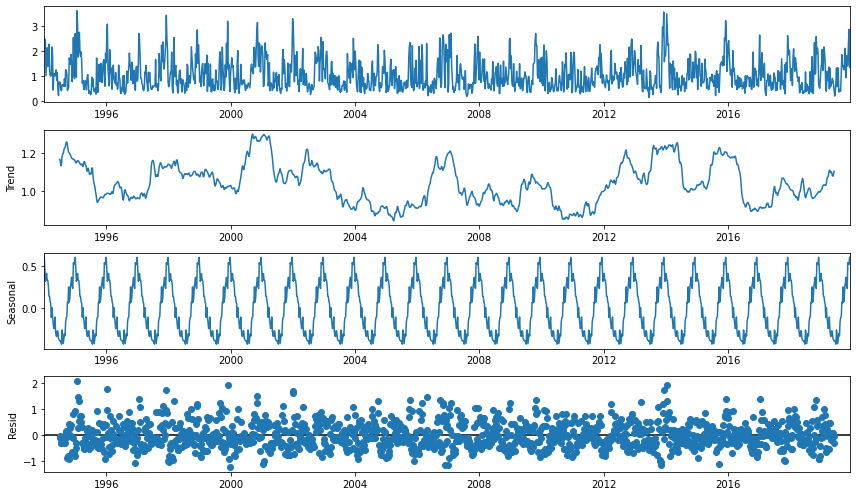

In [6]:
decomposition = sm.tsa.seasonal_decompose(df_resample,model='additive')
plt.rc("figure", figsize=(12,7))
fig=decomposition.plot()
plt.show()

In [7]:
# Adfuller test
adftest = adfuller(train_data)
adftest

(-8.995059191863707,
 6.729552558770943e-15,
 22,
 969,
 {'1%': -3.437116468121892,
  '5%': -2.864527318984441,
  '10%': -2.5683606077036214},
 1461.78435221076)

## Setup the hyperparameters

/home/jdasilva/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


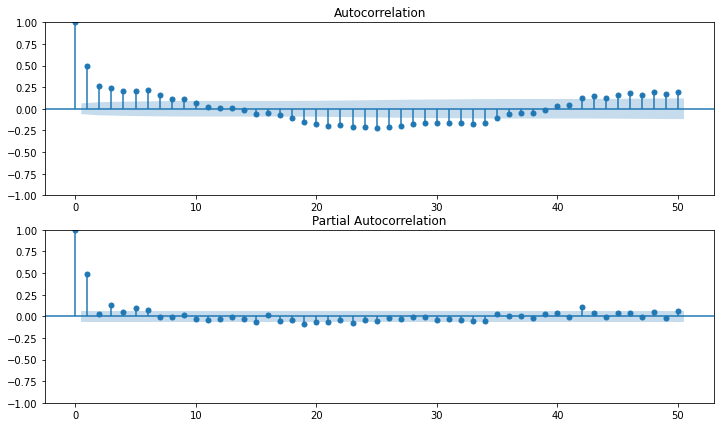

In [13]:
# plot acf and pacf
fig,ax = plt.subplots(2,figsize=(12,7))
ax[0] = plot_acf(train_data,ax=ax[0],lags=50)
ax[1] = plot_pacf(train_data,ax=ax[1],lags=50)

In [10]:
auto = auto_arima(train_data,
                  start_p=0,
                  start_q=0,
                  max_p=10,
                  max_q=10,
                  seasonal=True,
                  m=54,
                  start_P=0,
                  start_Q=0,
                  max_P=10,
                  max_Q=10,
                  trace=True).summary()
auto

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[54] intercept   : AIC=1809.308, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[54] intercept   : AIC=1520.325, Time=14.61 sec
 ARIMA(0,0,1)(0,0,1)[54] intercept   : AIC=1556.184, Time=6.59 sec
 ARIMA(0,0,0)(0,0,0)[54]             : AIC=3184.767, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[54] intercept   : AIC=1532.351, Time=0.12 sec
 ARIMA(1,0,0)(2,0,0)[54] intercept   : AIC=1518.468, Time=63.88 sec
 ARIMA(1,0,0)(3,0,0)[54] intercept   : AIC=1517.019, Time=238.57 sec
 ARIMA(1,0,0)(4,0,0)[54] intercept   : AIC=inf, Time=555.19 sec
 ARIMA(1,0,0)(3,0,1)[54] intercept   : AIC=1517.238, Time=639.56 sec
 ARIMA(1,0,0)(2,0,1)[54] intercept   : AIC=1516.336, Time=201.65 sec
 ARIMA(1,0,0)(1,0,1)[54] intercept   : AIC=inf, Time=43.67 sec
 ARIMA(1,0,0)(2,0,2)[54] intercept   : AIC=inf, Time=293.36 sec
 ARIMA(1,0,0)(1,0,2)[54] intercept   : AIC=inf, Time=407.86 sec
 ARIMA(1,0,0)(3,0,2)[54] intercept   : AIC=inf, Time=508.27 sec
 ARIMA(0,0,0)(2,0,1)[54] in

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  992
Model:             SARIMAX(1, 0, 0)x(2, 0, [1], 54)   Log Likelihood                -752.168
Date:                              Tue, 25 Jan 2022   AIC                           1516.336
Time:                                      16:32:25   BIC                           1545.734
Sample:                                           0   HQIC                          1527.513
                                              - 992                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1793      0.119      1.501      0.133      -0.055       0.414
ar.L1          0.4605      0.027     16.916      0.000       0.407       0.514
ar.S.L54       0.6755      0.256      2.641      0.008       0.174       1.177
ar.S.L108      0.0073      0.057      0.128      0.898      -0.104       0.118
ma.S.L54      -0.5581      0.255     -2.189      0.029      -1.058      -0.058
sigma2         0.2664      0.012     22.602      0.000       0.243       0.289
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               172.08
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.89
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Make predictions - week step

In [6]:
# fit and predict the model with the hyperparameters
model = SARIMAX(train_data,
                order=(1,0,0),
                seasonal_order=(2,0,1,54),
                enforce_stationarity=False,
                enforce_invertibility=False).fit()

prediction=model.predict(start=len(train_data),end=(len(df_resample)-1))

print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4644      0.028     16.612      0.000       0.410       0.519
ar.S.L54       0.8920      0.040     22.106      0.000       0.813       0.971
ar.S.L108      0.0641      0.037      1.744      0.081      -0.008       0.136
ma.S.L54      -0.7432      0.041    -18.170      0.000      -0.823      -0.663
sigma2         0.2876      0.012     24.301      0.000       0.264       0.311


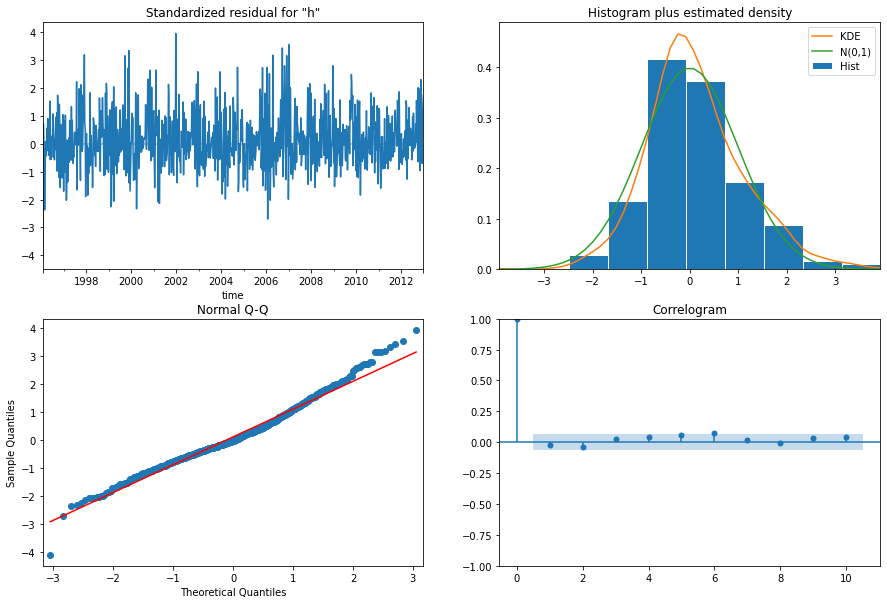

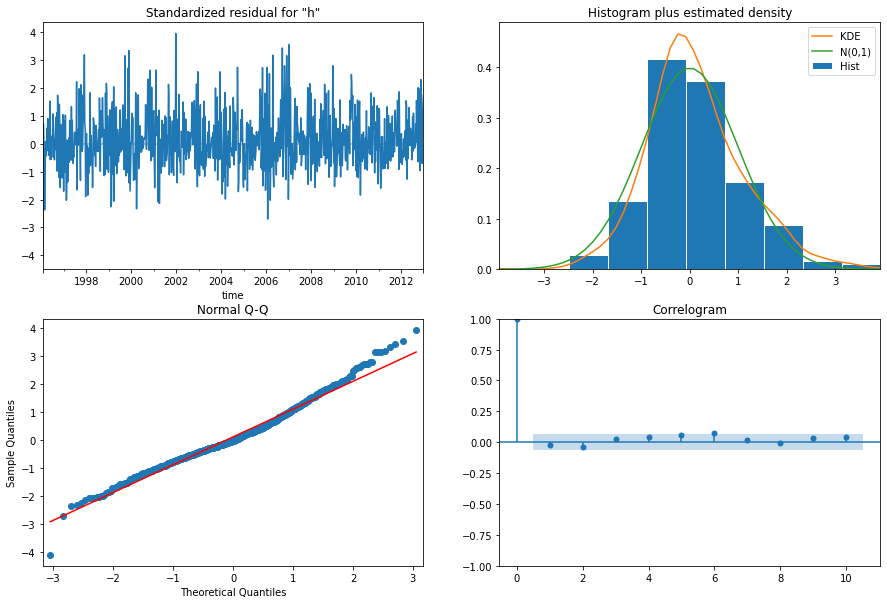

In [69]:
model.plot_diagnostics(figsize=(15,10))

****** RMSE : 0.6854027627908463 ******


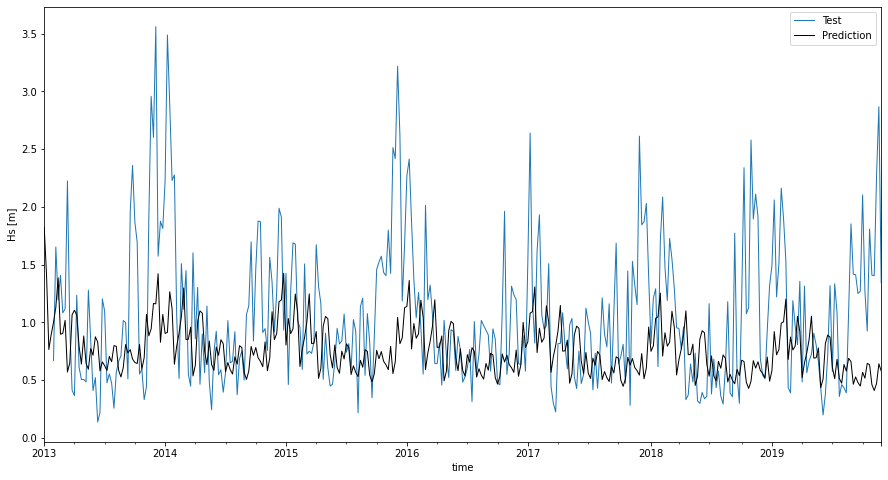

In [27]:
# plot the prediction
fig= plt.figure(figsize=((15,8)))
test_data.plot(legend=True, label='Test',linewidth=1)
prediction.plot(legend=True, label='Prediction',color='black',linewidth=1)
plt.ylabel('Hs [m]')

RMSE = np.sqrt(mean_squared_error(test_data,prediction[4:]))
print('****** RMSE : {} ******'.format(RMSE))
     

## Make predictions - month step

/home/jdasilva/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


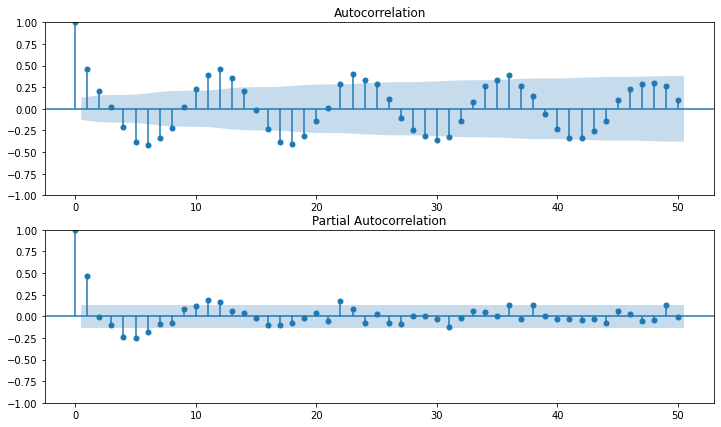

In [29]:
# Resample the data by month using mean
df_resample = pd.DataFrame(df['hs'].resample('M').mean())

# Split the data between train and test sets
train_end = datetime(2013,1,1)
test_end = datetime(2019,12,1)
train_data = df_resample['hs'][:train_end]
test_data = df_resample['hs'][train_end + relativedelta(months=+1):test_end]

# plot acf and pacf
fig,ax = plt.subplots(2,figsize=(12,7))
ax[0] = plot_acf(train_data,ax=ax[0],lags=50)
ax[1] = plot_pacf(train_data,ax=ax[1],lags=50)

In [76]:
auto = auto_arima(train_data,
                  start_p=0,
                  start_q=0,
                  max_p=15,
                  max_q=15,
                  seasonal=True,
                  m=12,
                  start_P=0,
                  start_Q=0,
                  max_P=15,
                  max_Q=15,

                  trace=True).summary()
auto

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=259.050, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=186.784, Time=0.64 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=194.548, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=702.927, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=204.924, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=186.013, Time=2.20 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=172.450, Time=6.93 sec
 ARIMA(1,0,0)(4,0,0)[12] intercept   : AIC=172.367, Time=12.11 sec
 ARIMA(1,0,0)(5,0,0)[12] intercept   : AIC=inf, Time=18.26 sec
 ARIMA(1,0,0)(4,0,1)[12] intercept   : AIC=163.699, Time=14.66 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=161.651, Time=5.67 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.74 sec
 ARIMA(1,0,0)(3,0,2)[12] intercept   : AIC=inf, Time=59.42 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=14.99 sec
 ARIMA(1,0,0)(4,0,2)[12] intercept   : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  228
Model:             SARIMAX(1, 0, 0)x(3, 0, [1], 12)   Log Likelihood                 -73.826
Date:                              Tue, 25 Jan 2022   AIC                            161.651
Time:                                      18:28:48   BIC                            185.657
Sample:                                           0   HQIC                           171.337
                                              - 228                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0141      0.017      0.818      0.413      -0.020       0.048
ar.L1          0.2210      0.068      3.231      0.001       0.087       0.355
ar.S.L12       1.0151      0.096     10.556      0.000       0.827       1.204
ar.S.L24      -0.1724      0.093     -1.862      0.063      -0.354       0.009
ar.S.L36       0.1399      0.085      1.641      0.101      -0.027       0.307
ma.S.L12      -0.8580      0.092     -9.340      0.000      -1.038      -0.678
sigma2         0.1057      0.011      9.895      0.000       0.085       0.127
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 3.70
Prob(Q):                              0.83   Prob(JB):                         0.16
Heteroskedasticity (H):               0.76   Skew:                             0.28
Prob(H) (two-sided):                  0.24   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
model = SARIMAX(train_data,
                order=(1,0,0),
                seasonal_order=(3,0,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False).fit()

prediction=model.predict(start=len(train_data),end=(len(df_resample)-1))

print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0891      0.067      1.330      0.183      -0.042       0.220
ar.S.L12       0.9435      0.076     12.349      0.000       0.794       1.093
ar.S.L24      -0.1313      0.103     -1.281      0.200      -0.332       0.070
ar.S.L36       0.1759      0.073      2.411      0.016       0.033       0.319
ma.S.L12      -1.0001    199.461     -0.005      0.996    -391.936     389.936
sigma2         0.0912     18.199      0.005      0.996     -35.578      35.760


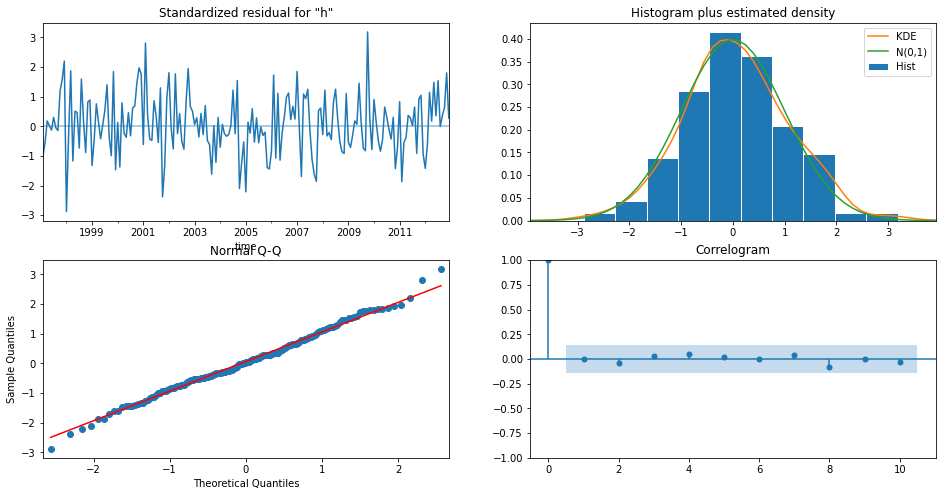

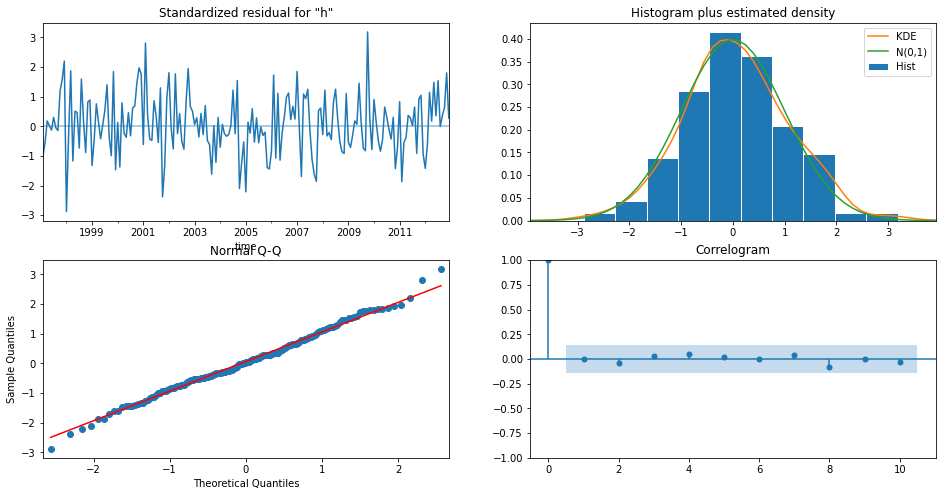

In [35]:
model.plot_diagnostics(figsize=(16,8))

****** RMSE : 0.4000221244018367 ******


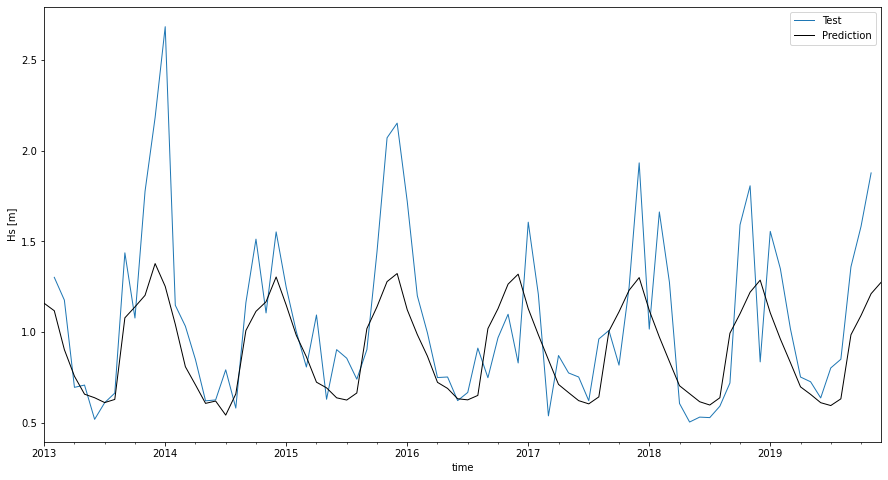

In [36]:
# plot the prediction
fig= plt.figure(figsize=((15,8)))
test_data.plot(legend=True, label='Test',linewidth=1)
prediction.plot(legend=True, label='Prediction',color='black',linewidth=1)
plt.ylabel('Hs [m]')

RMSE = np.sqrt(mean_squared_error(test_data,prediction[2:]))
print('****** RMSE : {} ******'.format(RMSE))